wordbatch example from Toxic Comment Classification Challenge　   
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
import pandas as pd
import numpy as np
import os, psutil
import matplotlib.pyplot as plt
import gc
import re
import time
from scipy.sparse import hstack
import threading
import wordbatch
from wordbatch.extractors import WordBag, WordHash
from nltk.corpus import stopwords
from wordbatch.models import FTRL
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from wordbatch.data_utils import *
%matplotlib inline 
np.random.seed(43)
seed=5

In [2]:
# read data
DIR = "~/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/"
train = pd.read_csv(DIR+'train.csv.zip')
test = pd.read_csv(DIR+'test.csv.zip')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
print("size of train data" +str(len(train)))
print("size of test data" +str(len(test)))

size of train data159571
size of test data153164


In [6]:
# labels 
category = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
ncat = len(category)

In [7]:
# rate of each label
train[category].mean()

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

In [8]:
# check the cpu usage
def cpuStats():
	pid = os.getpid()
	py = psutil.Process(pid)
	memoryUse = py.memory_info()[0] / 2. ** 30
	print('memory GB:', memoryUse)

In [9]:
# thread class
class ThreadWithReturnValue(threading.Thread):
	def __init__(self, group=None, target=None, name=None, args=(), kwargs=None, *, daemon=None):
		threading.Thread.__init__(self, group, target, name, args, kwargs, daemon=daemon)
		self._return = None
	def run(self):
		if self._target is not None:
			self._return = self._target(*self._args, **self._kwargs)
	def join(self):
		threading.Thread.join(self)
		return self._return

In [10]:
# fit function
def fit_batch(clf, X, y):  clf.partial_fit(X, y)

# predict
def predict_batch(clf, X):  return clf.predict(X)

# evaluate log loss score
def evaluate_batch(clf, X, y, rcount):
	score= roc_auc_score(y, predict_batch(clf, X))
	print(rcount, "score:", score) 
	return score

In [11]:
# stopword dict for wordbatch
stopwords_dict = {x: 1 for x in stopwords.words("english")}
non_alphanums = re.compile(u"[^A-Za-z0-9]+")
def normalize_text(text):
    return u" ".join([x for x in [y for y in non_alphanums.sub(' ', text).lower().strip().split(" ")] 
                      if len(x) > 1 and x not in stopwords_dict])

## WordHash + FTRL

In [12]:
# preprocess in dataframe
def dfpp(df, test=False):
    str_array = df["comment_text"].values
    if test != True:
        labels = df[category].values
    else:
        labels = []
    return str_array, labels

In [13]:
# define wordbatch class
D = 2 ** 14
batchsize = 50000
wb = wordbatch.WordBatch(normalize_text, extractor=(WordHash, {"ngram_range": (1, 1), "analyzer": "word",
                                                               "lowercase": False, "n_features": D,
                                                               "norm": None, "binary": True})
                         , minibatch_size=batchsize // 100, procs=8, freeze=True, timeout=1800, verbose=0)

In [14]:
# df to csr in wordbatch transformation
def transform_data(str_array):
    word_comment = wb.fit_transform(str_array)
    X = word_comment.tocsr()
    return X

In [15]:
rcount = 0
cpuStats()

clf = [FTRL(alpha=0.01, beta=0.01, L1=0.0, L2=0.0, D=D, iters=3, 
            inv_link="sigmoid", e_clip=1.0, threads=4, verbose=0) for _ in range(ncat)] # construct FTRL model in each label
start_time = time.time()

# training
for i in range(ncat):
    p = None
    for df_c in pd.read_csv(DIR+'train.csv.zip', engine='c', chunksize=batchsize):
        rcount += batchsize

        # extract text features for wordbatch
        str_array, labels= dfpp(df_c)
        del(df_c)

        if p != None:
            p.join() # waiting until finishing calculation
            del(X)
        gc.collect() # memory release

        X = transform_data(str_array) 
        del(str_array)

        # evaluate in each two loops
        if rcount % (2 * batchsize) == 0: 
            if p != None:  p.join()
            p = threading.Thread(target=evaluate_batch, args=(clf[i], X, labels[:,i], rcount)) # target: function, args: arguments for target function
            p.start() # thread start

        # Training iteration
        print("Training", rcount, time.time() - start_time)

        if p != None:  p.join()
        p = threading.Thread(target=fit_batch, args=(clf[i], X, labels[:,i])) # fit
        p.start() # thread start
    if p != None:  p.join()
        
cpuStats()
del(X)

memory GB: 0.3484458923339844
Training 50000 2.5120646953582764
Training 100000 25.310138940811157
100000 score: 0.8924493597003443
Training 150000 51.07358694076538
Training 200000 71.33137583732605
200000 score: 0.9152258144665792
Training 250000 78.6426727771759
Training 300000 102.54003691673279
300000 score: 0.8503735373289476
Training 350000 128.1520218849182
Training 400000 149.2258939743042
400000 score: 0.8888212413326568
Training 450000 156.68368077278137
Training 500000 180.9165198802948
500000 score: 0.8923746850407065
Training 550000 207.4435956478119
Training 600000 227.84057664871216
600000 score: 0.9278918186448487
Training 650000 235.30824995040894
Training 700000 257.3318028450012
700000 score: 0.783136621949792
Training 750000 282.62903785705566
Training 800000 303.8764867782593
800000 score: 0.7634978427597425
Training 850000 311.0306158065796
Training 900000 332.99555683135986
900000 score: 0.8750058046326588
Training 950000 359.9614179134369
Training 1000000 382.0

In [16]:
test_preds = [] 
rcount = 0

# test
for i in range(ncat):
    preds_one_category=[]
    p = None
    for df_c in pd.read_csv(DIR+'test.csv.zip', engine='c', chunksize=batchsize):
        rcount += batchsize
        if rcount % (10 * batchsize) == 0:
            print(rcount)
        str_array, labels = dfpp(df_c, test=True)
        del(df_c)
        if p != None:
            preds_one_category += list(p.join())
            del (X)
            gc.collect()
        X = transform_data(str_array)
        del (str_array)
        p = ThreadWithReturnValue(target=predict_batch, args=(clf[i], X)) # predict
        p.start()
    if p != None:  preds_one_category += list(p.join())
    test_preds.append(preds_one_category) # add prediction of one category
test_preds = np.array(test_preds).T

500000
1000000


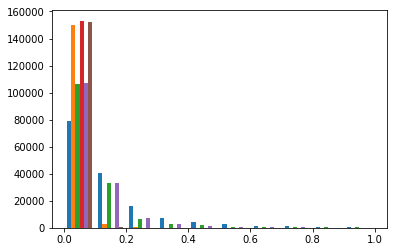

In [17]:
# predict distribution
plt.hist(test_preds,bins=10)
plt.show()

In [18]:
# save submit model
submit=pd.DataFrame(test_preds, columns=category)
submit=pd.concat([test["id"], submit],axis=1)
submit.to_csv("csv/ftrl.csv",index=None)

## WordBag + LogisticRegression

In [19]:
# merge train + test
merge = pd.concat([train.drop(["id"] + category, axis = 1), 
                   test.drop(["id"], axis = 1)], axis = 0)
merge.fillna(value = "no comment", inplace = True)

# define word batch
wb = wordbatch.WordBatch(normalize_text, 
                         extractor=(WordBag, {"hash_ngrams": 2, "hash_ngrams_weights": [1.0, 1.0],
                                              "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                              "idf": None}), procs=8)
wb.dictionary_freeze = True
word_comment = wb.fit_transform(merge["comment_text"])
word_comment = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

wb = wordbatch.WordBatch(normalize_text, 
                         extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                              "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                              "idf": None}), procs=8)
wb.dictionary_freeze = True
char_comment = wb.fit_transform(merge["comment_text"])
char_comment = char_comment[:, np.array(np.clip(char_comment.getnnz(axis=0) - 10, 0, 1), dtype = bool)]

# concat two features
comment = hstack((word_comment, char_comment)).tocsr()
nrow_train = train.shape[0]
X_train = comment[:nrow_train]
Y_train = train[category]
X_test = comment[nrow_train:]

Normalize text
Normalize text


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_model = LogisticRegression(C = 4, solver = "sag", max_iter = 100, random_state = seed)
cv_result = np.zeros((6, 3))
for i in range(ncat):
    cv_result[i, :] = -cross_val_score(lr_model, X_train, Y_train[category[i]], scoring = "neg_mean_squared_error")
print(cv_result)

[[0.04023237 0.04089114 0.04077834]
 [0.00943769 0.00970089 0.00949444]
 [0.0214322  0.02077458 0.02054898]
 [0.00278243 0.00293288 0.00248167]
 [0.02885827 0.02861386 0.02825772]
 [0.00774567 0.00772702 0.00782102]]


In [21]:
lr_prediction = np.zeros((test.shape[0], ncat))
for i in range(ncat):
    model = lr_model.fit(X_train, Y_train[category[i]])
    lr_prediction[:, i] = model.predict_proba(X_test)[:, 1]

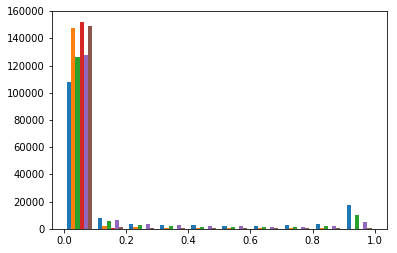

In [22]:
plt.hist(lr_prediction, bins=10)
plt.show()

In [23]:
submit=pd.DataFrame(lr_prediction, columns=category)
submit=pd.concat([test["id"], submit],axis=1)
submit.to_csv("csv/lr.csv",index=None)